# Objects in the Computational Domain
Solving the Laplace equation with sink and insulating objects using SOR.

## Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import os

out_dir="outputs_objects"
os.makedirs(out_dir, exist_ok=True)

N=50
eps=1e-5
x=np.linspace(0,1,N+1)
y=np.linspace(0,1,N+1)
X, Y=np.meshgrid(x, y, indexing='ij')

## Mask Creation
Encode objects on the grid:
- `0` = fluid (normal SOR update)
- `1` = sink (c forced to 0)
- `2` = insulating (zero-flux BC)

In [2]:
def make_mask(N, rects, kind=1):
    mask=np.zeros((N+1,N+1), dtype=np.int64)
    for i0, i1, j0, j1 in rects:
        mask[i0:i1+1, j0:j1+1]=kind
    return mask

## SOR Solver with Object Support
- **Sink** (`mask==1`): force `c=0`, skip SOR update
- **Insulating** (`mask==2`): skip point; fluid neighbours use reflected values to enforce zero flux

In [3]:
@njit
def sor_objects(N, eps, omega, mask):
    c=np.zeros((N+1,N+1))
    c[:,N]=1.0
    c[:,0]=0.0

    # initialise sink points to zero
    for i in range(N+1):
        for j in range(N+1):
            if mask[i,j]==1:
                c[i,j]=0.0

    max_iter=200000
    dels=np.zeros(max_iter)
    k=0

    while k<max_iter:
        delta=0.0

        for i in range(N):
            ip=(i+1)%N
            im=(i-1)%N
            for j in range(1,N):
                # sink: force c=0, skip SOR update
                if mask[i,j]==1:
                    c[i,j]=0.0
                    continue
                # insulating interior: not part of fluid domain
                if mask[i,j]==2:
                    continue

                old=c[i,j]

                # for each neighbour, reflect at insulating surfaces
                c_e=c[i,j] if mask[ip,j]==2 else c[ip,j]
                c_w=c[i,j] if mask[im,j]==2 else c[im,j]
                c_n=c[i,j] if mask[i,j+1]==2 else c[i,j+1]
                c_s=c[i,j] if mask[i,j-1]==2 else c[i,j-1]

                gs=0.25*(c_e+c_w+c_n+c_s)
                c[i,j]=(1.0-omega)*old + omega*gs
                delta=max(delta, abs(c[i,j]-old))

        # re-enforce boundary conditions
        c[:,0]=0.0
        c[:,N]=1.0
        for i in range(N+1):
            for j in range(N+1):
                if mask[i,j]==1:
                    c[i,j]=0.0

        dels[k]=delta
        k+=1
        if delta<eps:
            break

    # copy periodic boundary so row N matches row 0
    c[N,:]=c[0,:]
    return c, dels[:k], k

## Plotting Helpers

In [4]:
def plot_field(c, mask, title, fname):
    fig, ax=plt.subplots(figsize=(7,6))
    c_vis=np.copy(c)
    c_vis[mask>0]=np.nan
    c_ma=np.ma.masked_invalid(c_vis)
    im=ax.pcolormesh(X, Y, c_ma, vmin=0, vmax=1, cmap='hot', shading='auto')
    if np.any(mask>0):
        obj=np.ma.masked_where(mask==0, np.ones_like(c))
        ax.pcolormesh(X, Y, obj, cmap='Greys', vmin=0, vmax=2,
                      shading='auto', alpha=0.6)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax, label='c')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, fname), dpi=150)
    plt.show()


def plot_conv(curves, title, fname):
    plt.figure(figsize=(8,6))
    for lbl, d in curves.items():
        plt.semilogy(range(1, len(d)+1), d, label=lbl)
    plt.xlabel('Iteration k')
    plt.ylabel('δ')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, fname), dpi=150)
    plt.show()


def plot_opt(omegas, iters_dict, fname):
    plt.figure(figsize=(7,5))
    for label, iters in iters_dict.items():
        b_idx=np.argmin(iters)
        b_omega=omegas[b_idx]
        b_iters=iters[b_idx]
        plt.plot(omegas, iters, 'o-', ms=3,
                 label=f'{label}  (ω*={b_omega:.2f}, {b_iters})')
    plt.xlabel('ω')
    plt.ylabel('Iterations')
    plt.title('SOR: Iterations vs ω')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, fname), dpi=150)
    plt.show()

## Object Configurations
Define sink (`kind=1`) and insulating (`kind=2`) masks for three rectangle geometries.

In [5]:
no_obj=np.zeros((N+1,N+1), dtype=np.int64)

# --- sink objects (kind=1): concentration forced to zero ---
one_rect_sink=make_mask(N, [(20,30,20,30)], kind=1)
two_rect_sink=make_mask(N, [(10,15,15,25),(35,40,25,35)], kind=1)
big_rect_sink=make_mask(N, [(15,35,18,32)], kind=1)

# --- insulating objects (kind=2): zero-flux boundary ---
one_rect_ins=make_mask(N, [(20,30,20,30)], kind=2)
two_rect_ins=make_mask(N, [(10,15,15,25),(35,40,25,35)], kind=2)
big_rect_ins=make_mask(N, [(15,35,18,32)], kind=2)

w0=1.8
omegas=np.arange(1.0, 2.0, 0.02)

## Part K: Sink Objects
### Concentration fields and iteration counts at ω = 1.8

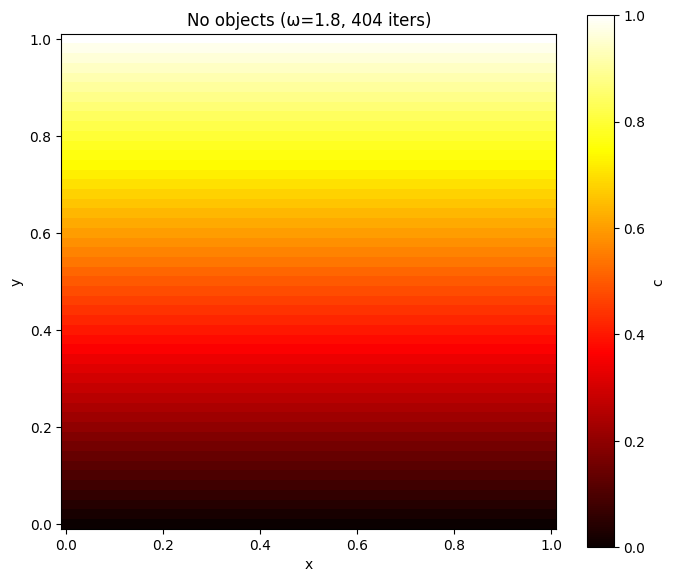

  No objects              ->     404 iterations


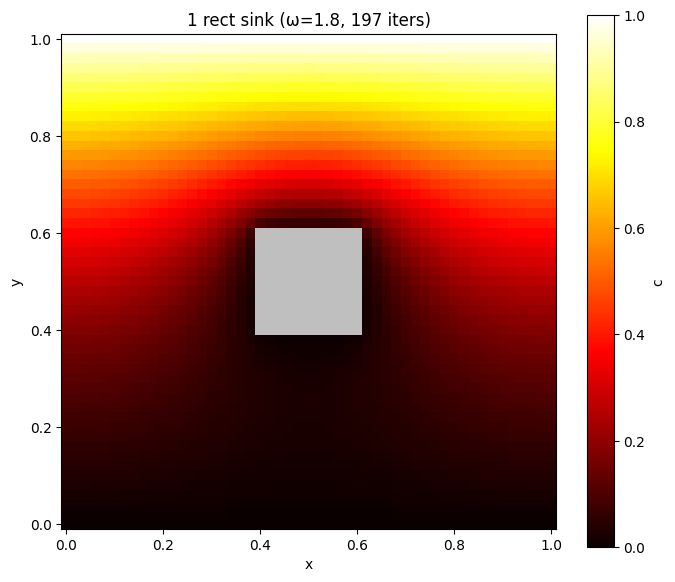

  1 rect sink             ->     197 iterations


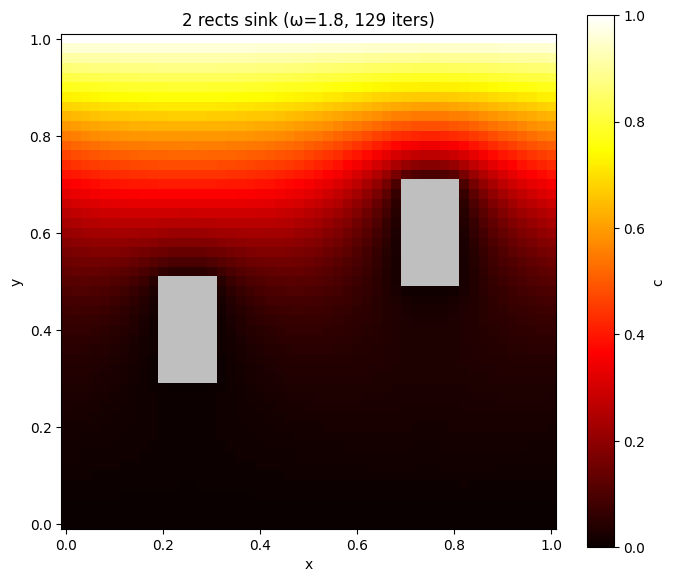

  2 rects sink            ->     129 iterations


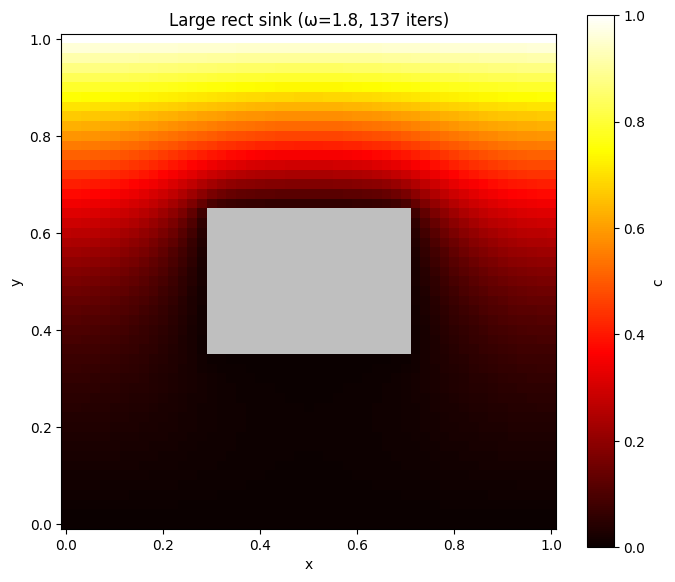

  Large rect sink         ->     137 iterations


In [6]:
sink_configs=[
    ("No objects",      no_obj,        "no_obj"),
    ("1 rect sink",     one_rect_sink, "1rect_sink"),
    ("2 rects sink",    two_rect_sink, "2rect_sink"),
    ("Large rect sink", big_rect_sink, "big_sink"),
]

conv_sink={}
for label, msk, tag in sink_configs:
    c, dels, k=sor_objects(N, eps, w0, msk)
    plot_field(c, msk, f"{label} (ω={w0}, {k} iters)", f"field_{tag}.png")
    conv_sink[f"{label} ({k})"]=dels
    print(f"  {label:22s}  ->  {k:>6d} iterations")

### Convergence curves (sink)

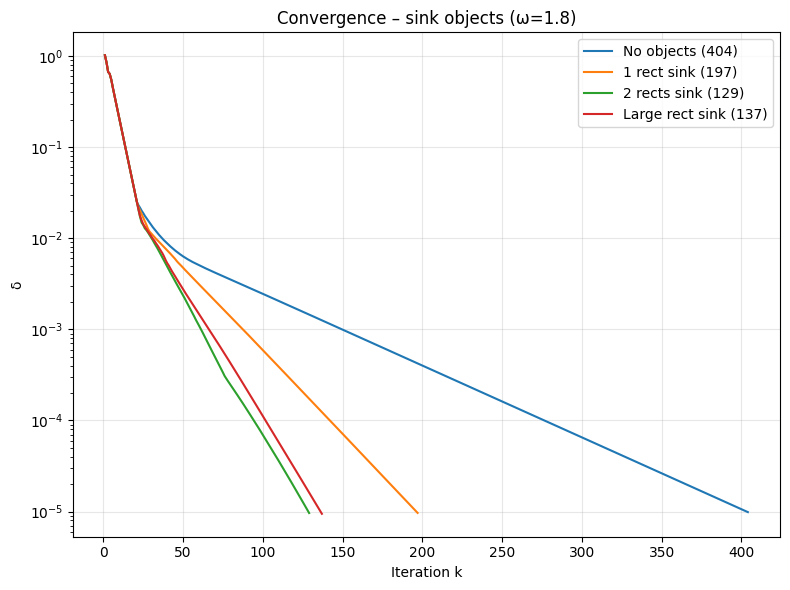

In [7]:
plot_conv(conv_sink, "Convergence – sink objects (ω=1.8)", "conv_sink.png")

### Optimal ω sweep (sink)

  No objects              ->  optimal ω = 1.92  (166 iters)
  1 rect sink             ->  optimal ω = 1.88  (120 iters)
  2 rects sink            ->  optimal ω = 1.86  (104 iters)
  Large rect sink         ->  optimal ω = 1.84  (106 iters)


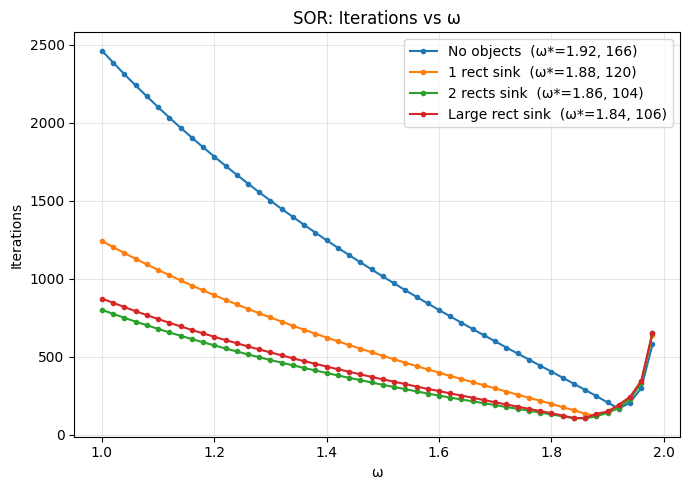

In [8]:
iters_sink={}
for label, msk, tag in sink_configs:
    it=np.empty(len(omegas), dtype=np.int64)
    for idx in range(len(omegas)):
        _, _, kk=sor_objects(N, eps, omegas[idx], msk)
        it[idx]=kk
    iters_sink[label]=it
    b=np.argmin(it)
    print(f"  {label:22s}  ->  optimal ω = {omegas[b]:.2f}  ({it[b]} iters)")

plot_opt(omegas, iters_sink, "omega_sink.png")

### Side-by-side comparison of all sink configurations

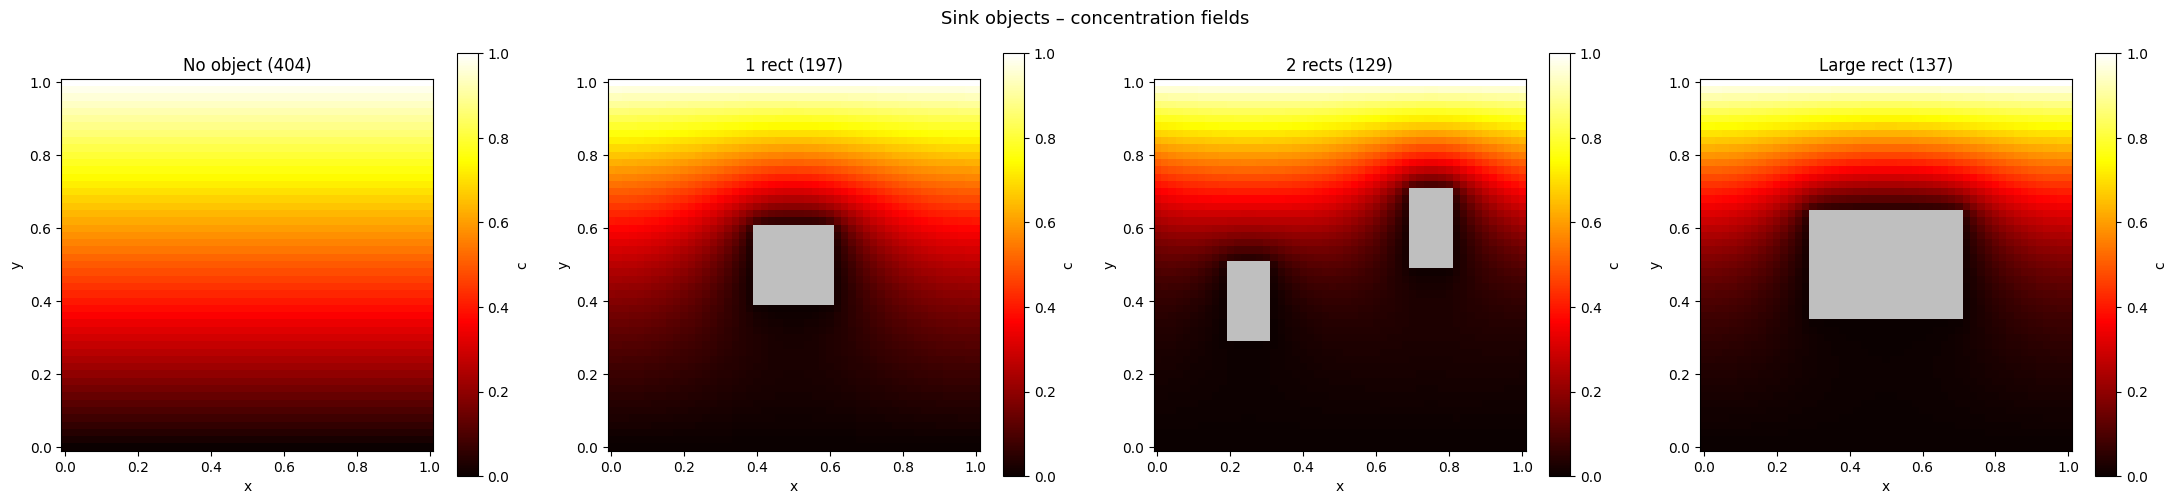

In [9]:
c_none, _, k_none=sor_objects(N, eps, w0, no_obj)
c_one,  _, k_one =sor_objects(N, eps, w0, one_rect_sink)
c_two,  _, k_two =sor_objects(N, eps, w0, two_rect_sink)
c_big,  _, k_big =sor_objects(N, eps, w0, big_rect_sink)

fig, axes=plt.subplots(1, 4, figsize=(22,5))
for ax, cd, msk, ttl in zip(
    axes,
    [c_none, c_one, c_two, c_big],
    [no_obj, one_rect_sink, two_rect_sink, big_rect_sink],
    [f"No object ({k_none})", f"1 rect ({k_one})",
     f"2 rects ({k_two})", f"Large rect ({k_big})"]
):
    c_vis=np.copy(cd)
    c_vis[msk>0]=np.nan
    c_ma=np.ma.masked_invalid(c_vis)
    im=ax.pcolormesh(X, Y, c_ma, vmin=0, vmax=1, cmap='hot', shading='auto')
    if np.any(msk>0):
        obj=np.ma.masked_where(msk==0, np.ones_like(cd))
        ax.pcolormesh(X, Y, obj, cmap='Greys', vmin=0, vmax=2,
                      shading='auto', alpha=0.6)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(ttl)
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax, label='c')

plt.suptitle("Sink objects – concentration fields", fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "comparison_sinks.png"), dpi=150)
plt.show()

### Mid-slice profiles (sink)

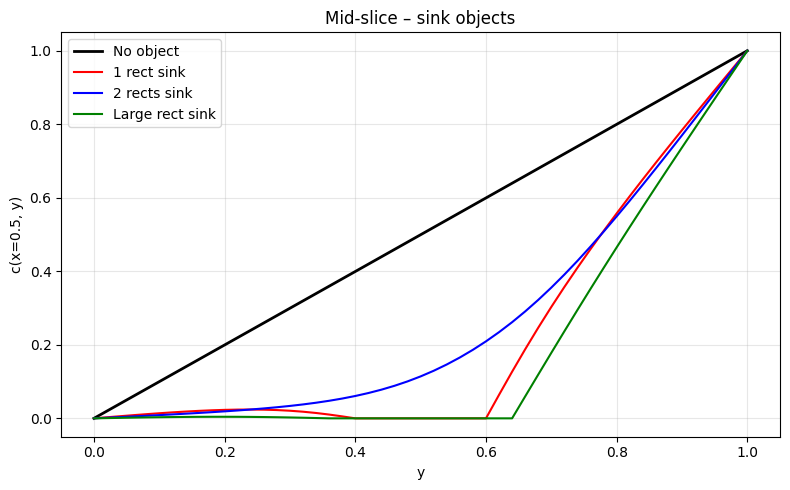

In [10]:
mid=N//2
plt.figure(figsize=(8,5))
plt.plot(y, c_none[mid,:], 'k-',  lw=2,   label='No object')
plt.plot(y, c_one[mid,:],  'r-',  lw=1.5, label='1 rect sink')
plt.plot(y, c_two[mid,:],  'b-',  lw=1.5, label='2 rects sink')
plt.plot(y, c_big[mid,:],  'g-',  lw=1.5, label='Large rect sink')
plt.xlabel('y')
plt.ylabel('c(x=0.5, y)')
plt.title('Mid-slice – sink objects')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "midslice_sinks.png"), dpi=150)
plt.show()

## Part L: Insulating Objects
### Concentration fields and iteration counts at ω = 1.8

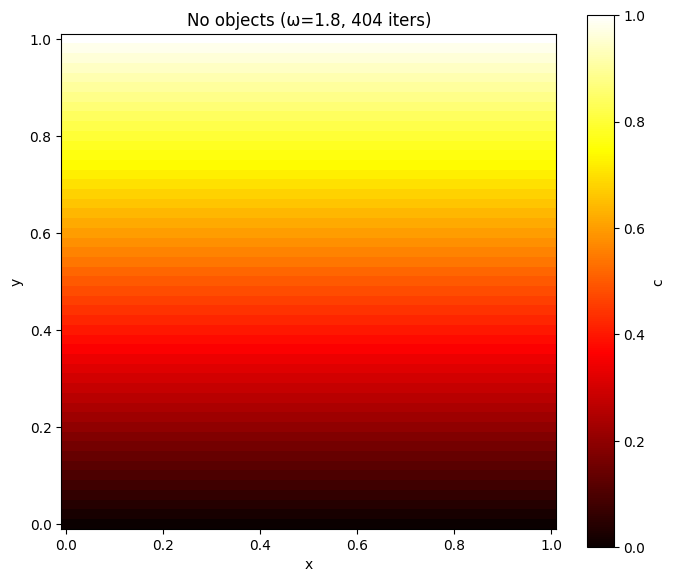

  No objects              ->     404 iterations


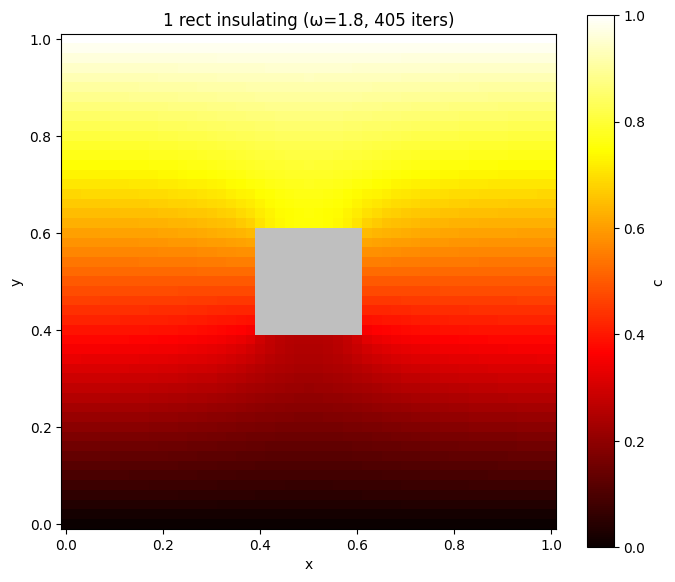

  1 rect insulating       ->     405 iterations


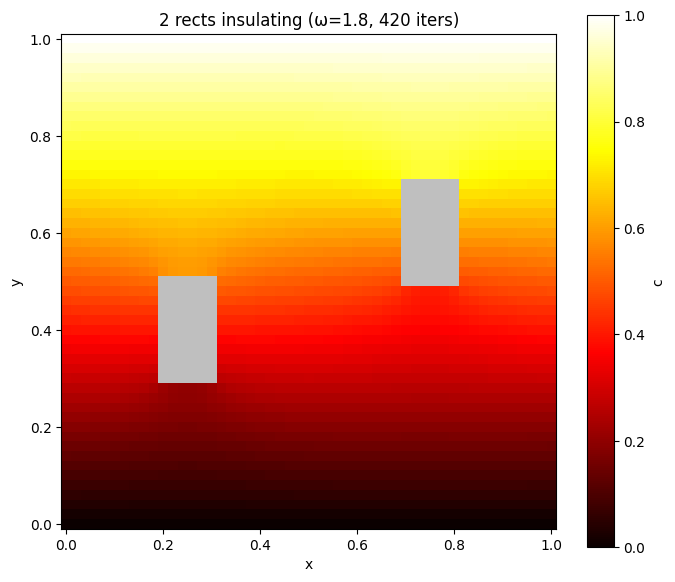

  2 rects insulating      ->     420 iterations


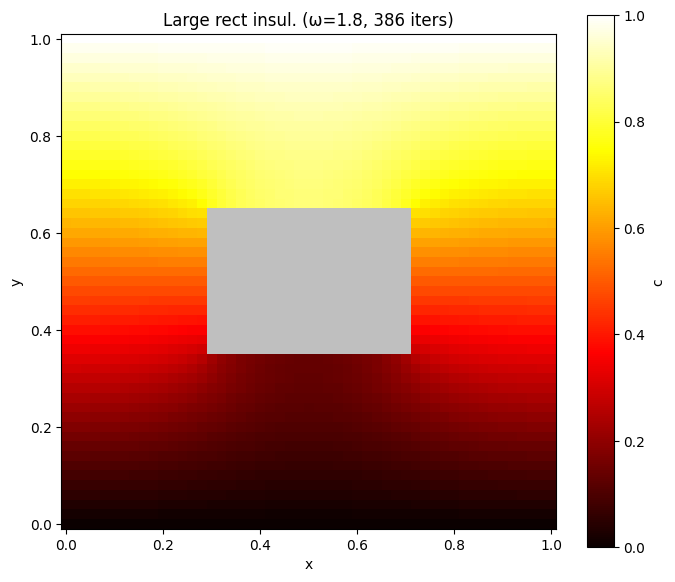

  Large rect insul.       ->     386 iterations


In [11]:
ins_configs=[
    ("No objects",         no_obj,       "no_obj_ins"),
    ("1 rect insulating",  one_rect_ins, "1rect_ins"),
    ("2 rects insulating", two_rect_ins, "2rect_ins"),
    ("Large rect insul.",  big_rect_ins, "big_ins"),
]

conv_ins={}
for label, msk, tag in ins_configs:
    c, dels, k=sor_objects(N, eps, w0, msk)
    plot_field(c, msk, f"{label} (ω={w0}, {k} iters)", f"field_{tag}.png")
    conv_ins[f"{label} ({k})"]=dels
    print(f"  {label:22s}  ->  {k:>6d} iterations")

### Convergence curves (insulating)

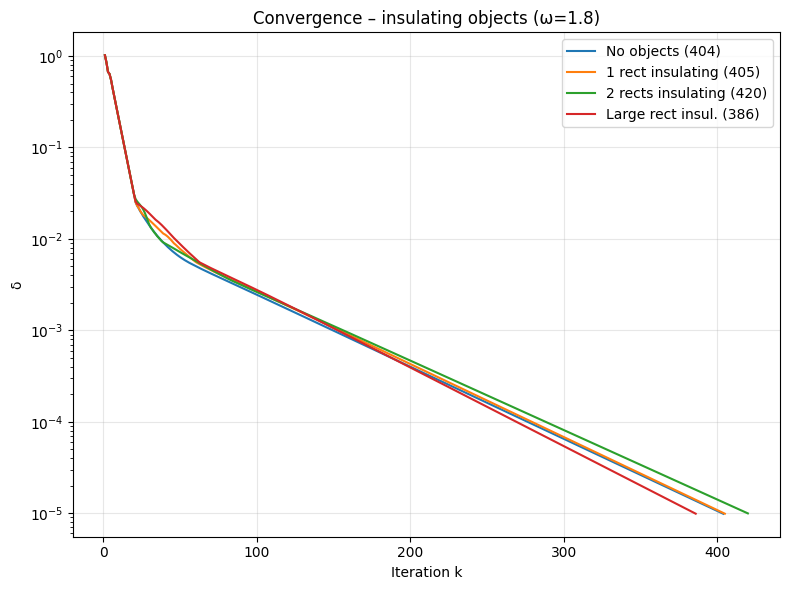

In [12]:
plot_conv(conv_ins, "Convergence – insulating objects (ω=1.8)", "conv_insulating.png")

### Optimal ω sweep (insulating)

  No objects              ->  optimal ω = 1.92  (166 iters)
  1 rect insulating       ->  optimal ω = 1.94  (183 iters)
  2 rects insulating      ->  optimal ω = 1.94  (182 iters)
  Large rect insul.       ->  optimal ω = 1.94  (175 iters)


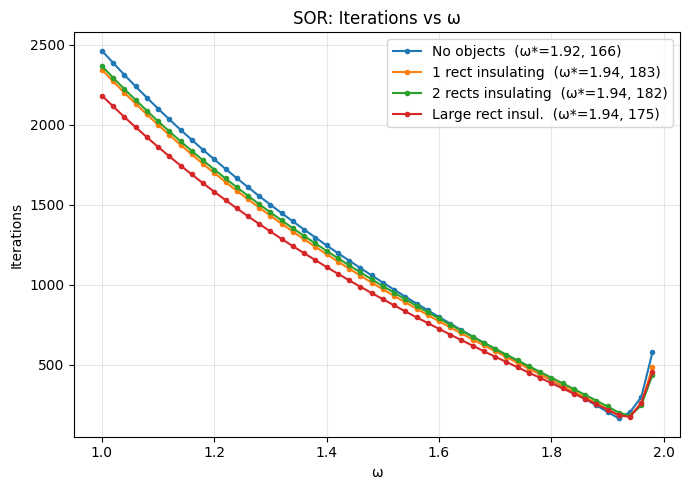

In [13]:
iters_ins={}
for label, msk, tag in ins_configs:
    it=np.empty(len(omegas), dtype=np.int64)
    for idx in range(len(omegas)):
        _, _, kk=sor_objects(N, eps, omegas[idx], msk)
        it[idx]=kk
    iters_ins[label]=it
    b=np.argmin(it)
    print(f"  {label:22s}  ->  optimal ω = {omegas[b]:.2f}  ({it[b]} iters)")

plot_opt(omegas, iters_ins, "omega_insulating.png")

## Comparison: Sink vs Insulating (same centred rectangle)
### Three-panel heatmap

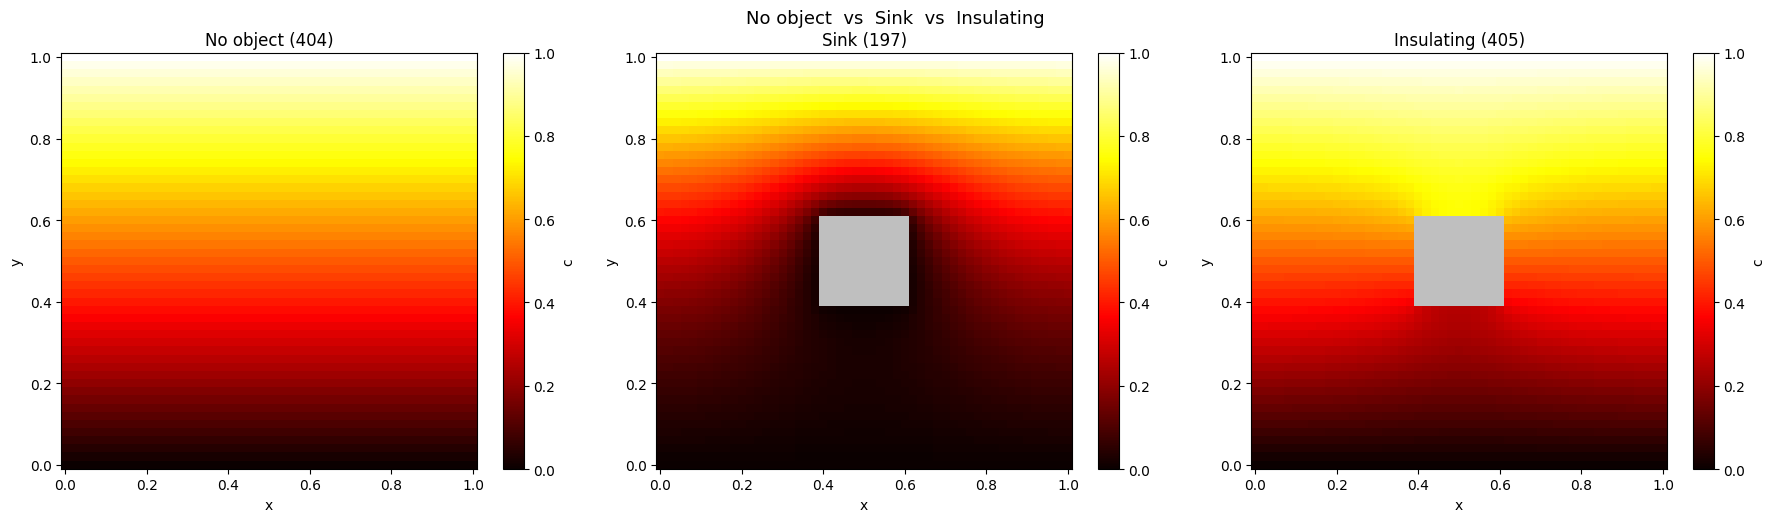

In [14]:
c_none, _, k_none=sor_objects(N, eps, w0, no_obj)
c_sink, _, k_sink=sor_objects(N, eps, w0, one_rect_sink)
c_ins,  _, k_ins =sor_objects(N, eps, w0, one_rect_ins)

fig, axes=plt.subplots(1, 3, figsize=(18,5))
for ax, cd, msk, ttl in zip(
    axes,
    [c_none, c_sink, c_ins],
    [no_obj, one_rect_sink, one_rect_ins],
    [f"No object ({k_none})", f"Sink ({k_sink})", f"Insulating ({k_ins})"]
):
    c_vis=np.copy(cd)
    c_vis[msk>0]=np.nan
    c_ma=np.ma.masked_invalid(c_vis)
    im=ax.pcolormesh(X, Y, c_ma, vmin=0, vmax=1, cmap='hot', shading='auto')
    if np.any(msk>0):
        obj=np.ma.masked_where(msk==0, np.ones_like(cd))
        ax.pcolormesh(X, Y, obj, cmap='Greys', vmin=0, vmax=2,
                      shading='auto', alpha=0.6)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(ttl)
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax, label='c')

plt.suptitle("No object  vs  Sink  vs  Insulating", fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "comparison_3way.png"), dpi=150)
plt.show()

### Mid-slice: sink vs insulating vs no object

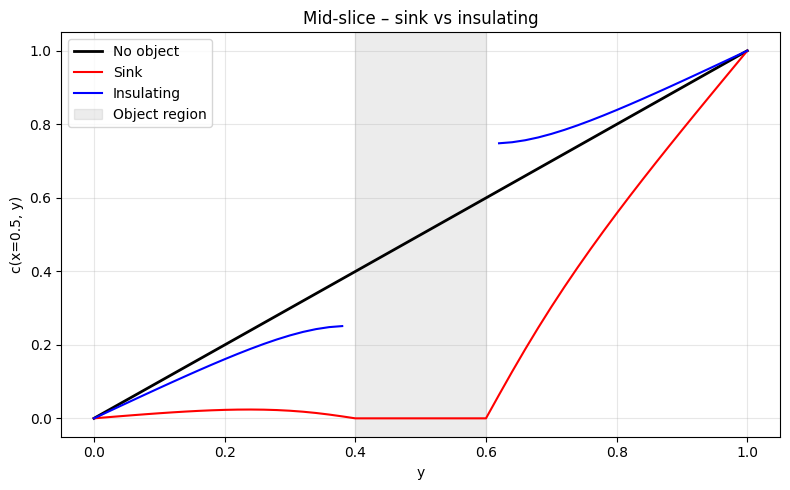


  No object:     404 iterations
  Sink:          197 iterations
  Insulating:    405 iterations


In [15]:
plt.figure(figsize=(8,5))
plt.plot(y, c_none[mid,:], 'k-',  lw=2,   label='No object')
plt.plot(y, c_sink[mid,:], 'r-',  lw=1.5, label='Sink')
c_ins_slice=np.copy(c_ins[mid,:])
c_ins_slice[one_rect_ins[mid,:]==2]=np.nan
plt.plot(y, c_ins_slice,   'b-',  lw=1.5, label='Insulating')
plt.axvspan(y[20], y[30], alpha=0.15, color='grey', label='Object region')
plt.xlabel('y')
plt.ylabel('c(x=0.5, y)')
plt.title('Mid-slice – sink vs insulating')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "midslice_comparison.png"), dpi=150)
plt.show()

print(f"\n  No object:  {k_none:>6d} iterations")
print(f"  Sink:       {k_sink:>6d} iterations")
print(f"  Insulating: {k_ins:>6d} iterations")